In [1]:
import sys
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

current_dir = Path.cwd()
src_path = current_dir.parent / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from config import FEATURES_OUTPUT_DIR

In [2]:
feature_file = FEATURES_OUTPUT_DIR / "features_2010.parquet"
df = pl.read_parquet(feature_file)

df.shape

(681921, 6)

In [4]:
# Look at the Flash Crash Week, we'd like to see the flash crash stands out
start_date = datetime(2010, 5, 3)
end_date = datetime(2010, 5, 8)

df_week = df.filter(
    (pl.col("timestamp") >= start_date) & 
    (pl.col("timestamp") <= end_date)
)

In [5]:
# Aggregate across the market so we get a market-wide signal, we use robust metric median so we avoid outliers effect
market_signal = (
    df_week.group_by("timestamp")
    .agg([
        pl.col("R_tau").median().alias("Market_Fragility"),
        pl.col("volatility").median().alias("Market_Volatility")
    ])
    .sort("timestamp")
)

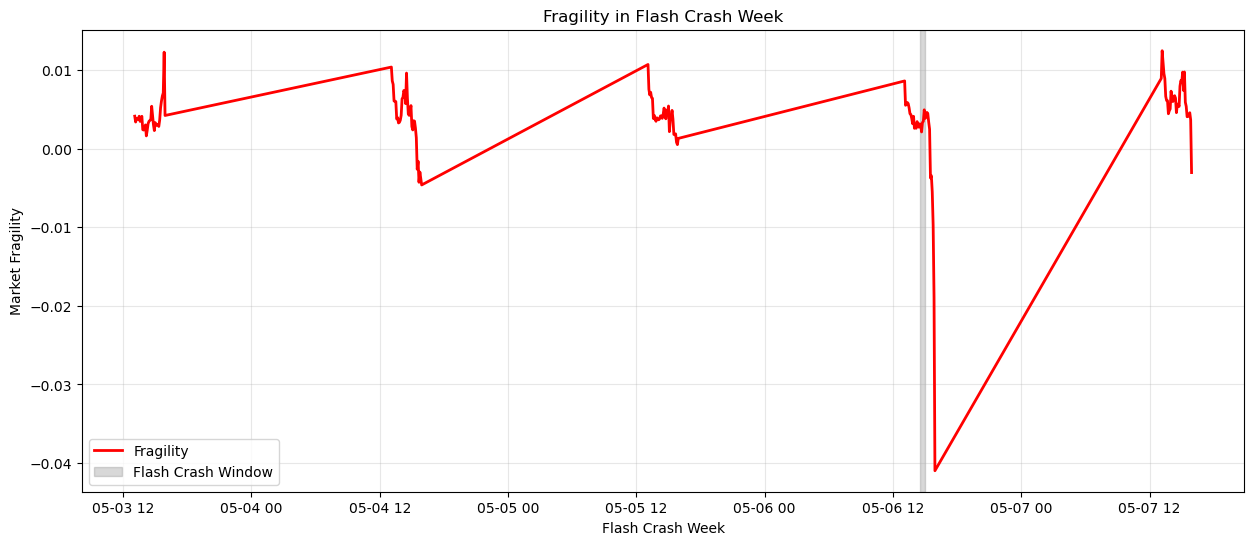

In [10]:
# We plot fragility
fig, ax1 = plt.subplots(figsize=(15, 6))

pdf = market_signal.to_pandas()

ax1.set_xlabel('Flash Crash Week')
ax1.set_ylabel('Market Fragility')
ax1.plot(pdf['timestamp'], pdf['Market_Fragility'], color='r', linewidth=2, label="Fragility")

# Highlight the flash crash
ax1.axvspan(
    datetime(2010, 5, 6, 14, 30), 
    datetime(2010, 5, 6, 15, 0), 
    color='gray', alpha=0.3, label="Flash Crash Window"
)

plt.title("Fragility in Flash Crash Week")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [11]:
# Select flash crash day and a random normal day
crash_day = df.filter(
    (pl.col("timestamp") >= datetime(2010, 5, 6, 9, 30)) & 
    (pl.col("timestamp") <= datetime(2010, 5, 6, 16, 0))
).group_by("timestamp").agg(pl.col("R_tau").median().alias("fragility")).sort("timestamp")

normal_day = df.filter(
    (pl.col("timestamp") >= datetime(2010, 4, 15, 9, 30)) & 
    (pl.col("timestamp") <= datetime(2010, 4, 15, 16, 0))
).group_by("timestamp").agg(pl.col("R_tau").median().alias("fragility")).sort("timestamp")

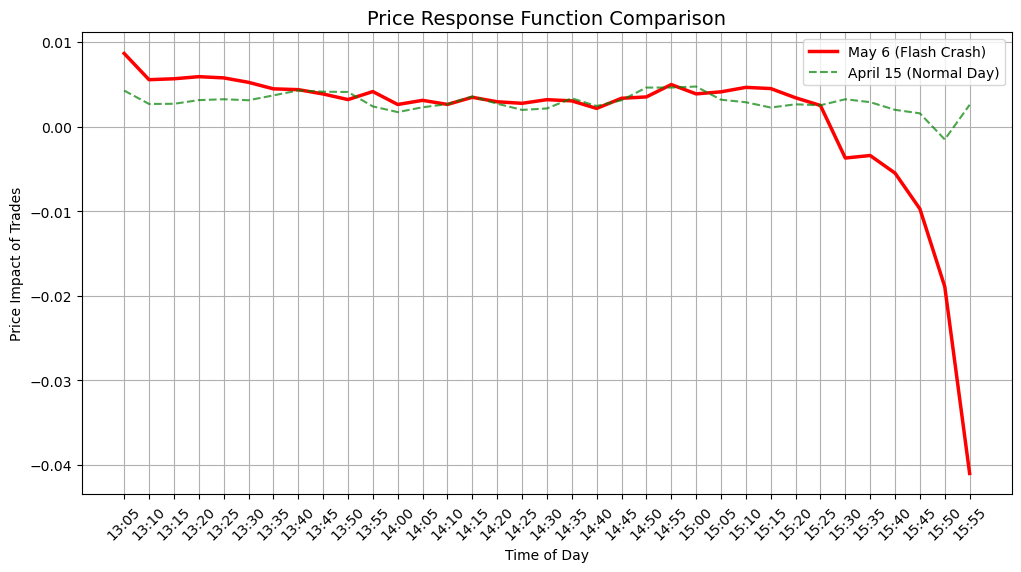

In [13]:
plt.figure(figsize=(12, 6))

plt.plot(crash_day["timestamp"].dt.strftime("%H:%M"), crash_day["fragility"], 
         color="red", linewidth=2.5, label="May 6 (Flash Crash)")

plt.plot(normal_day["timestamp"].dt.strftime("%H:%M"), normal_day["fragility"], 
         color="green", linestyle="--", alpha=0.7, label="April 15 (Normal Day)")

plt.title("Price Response Function Comparison", fontsize=14)
plt.ylabel("Price Impact of Trades")
plt.xlabel("Time of Day")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()